In [122]:
# Now do https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

import torch
import torchvision

torch.manual_seed(42)

from utils_bodies import MyDataset, plot_boundry_boxes

import utils

print(torch.__version__)
print(torchvision.__version__)

1.7.0
0.8.1


work (ish):
1.7.0
0.8.1

no work: 
1.9.0
0.9.0a0

# Using vanilla model
(faster R-CNN + resnet50 fpn)

In [123]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=True, pretrained_backbone=True)

In [124]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [125]:
dataset = MyDataset()

In [126]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4, collate_fn=utils.collate_fn) # still do not get the error when using higher batch_size...

model.eval()

predictions = []
images = []
targets = []
epochs = 4
for e in range(epochs):

    image,target = next(iter(data_loader))

    images.append(image)
    targets.extend(target)

    prediction = model(image)
    predictions.extend(prediction)  

In [127]:
# plot_boundry_boxes(dataset, images, targets, predictions)

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_costum(dataset, images, targets, predictions):

    """....."""

    # dict for targets, int to str
    t_inst_classes = dataset.target_classes()
    inst_classes = dataset.coco_classes()
    
    n = len(images) # should be 4.. or a square number: 1, 4, 9, 16, 25, 36, 49
    plt.figure(figsize = [15,10])

    for i,j in enumerate(images): # iterate over images i
        img = j[0].detach().numpy() # detach from device and tensor to numpy. j is now a touple with one entry... idk..
        img = img.squeeze() # remove batch dim so b,c,h,w -> c,h,w
        img = np.moveaxis(img, 0, -1) # move channels back so c,h,w -> h,w,c
        # note image is still range (0,1)

        plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i+1)
        plt.subplots_adjust(hspace = 0.2, wspace = 0.1)
        plt.imshow(img)
        # plt.title('test')

        threshold = .8 # needs to be and input to the function
        color1 = 'orange' # needs to vary according to class
        color2 = 'salmon' # needs to vary according to class

        n_obj = predictions[i]['boxes'].shape[0]

        #plot prediction boundry boxes
        for k in range(n_obj): # iterate over objects j in image i
            
            if predictions[i]['scores'][k] > threshold: # is the predictions clear the threshold

                box = predictions[i]['boxes'][k].detach().numpy() # boxes in xmin, ymin, xmax, ymax format

                xmin = box[0]
                ymin = box[1]
                xmax = box[2]
                ymax = box[3]

                xdiff = xmax - xmin
                ydiff = ymax - ymin

                plt.annotate(inst_classes[predictions[i]['labels'][k]], [xmin, ymax], fontsize = 20, color = color1) 
                # you use inst_classes here!!! that list needs to be loaded from somewhere..
                            
                rect = Rectangle((xmin, ymin),xdiff,ydiff,linewidth = 2, edgecolor = color1, facecolor='none')
                    
                ax = plt.gca()
                ax.add_patch(rect)

        #plot target boundry boxes. if-statment handelse images with only one box = one less dim.
        if len(targets[i]['boxes'].shape) == 3:
            t_obj = targets[i]['boxes'].squeeze()
            t_label = targets[i]['labels'].squeeze()

        elif len(targets[i]['boxes'].shape) == 2:
            t_obj = targets[i]['boxes']
            t_label = targets[i]['labels']

        else:
            print('wrong dims...')

        for m, l in enumerate(t_obj): # for target l in images i. and squeeze to remove batch dim
                
                t_box = l.detach().numpy() # boxes in xmin, ymin, xmax, ymax format

                t_xmin = t_box[0]
                t_ymin = t_box[1]
                t_xmax = t_box[2]
                t_ymax = t_box[3]

                t_xdiff = t_xmax - t_xmin
                t_ydiff = t_ymax - t_ymin

                plt.annotate(t_inst_classes[t_label[m].item()], [t_xmin, t_ymax-np.abs(np.random.normal(loc = 0, scale = 100, size = 1))], fontsize = 20, color = color2)
                            
                t_rect = Rectangle((t_xmin, t_ymin), t_xdiff, t_ydiff, linewidth = 2, edgecolor = color2, facecolor='none')
                    
                ax = plt.gca()
                ax.add_patch(t_rect)

        # plot image 
        # plt.imshow(img)
        # plt.title('test')
    plt.savefig(f'viz_FRCNN.pdf', bbox_inches="tight")    
    plt.show()

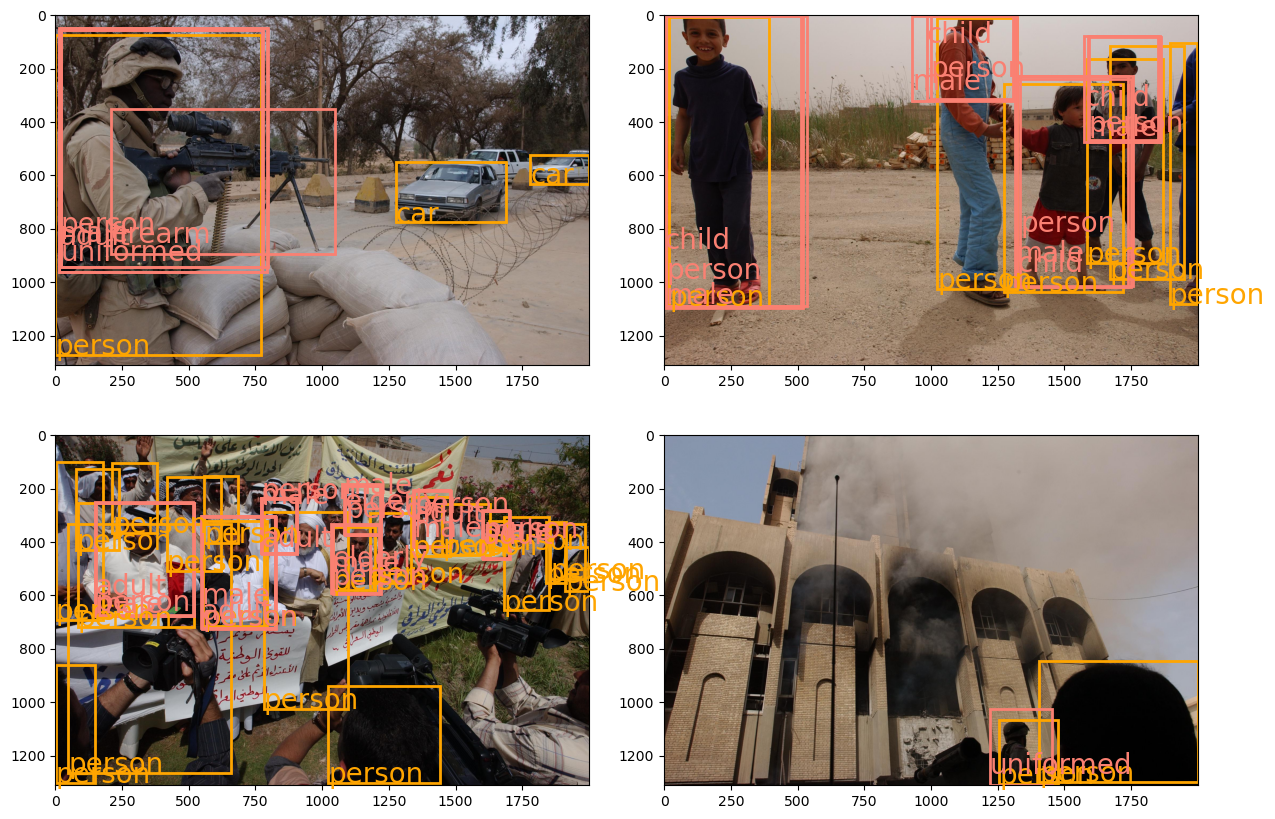

In [131]:
plot_costum(dataset, images, targets, predictions)
plt.show()